In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from networkx.algorithms.community import greedy_modularity_communities
from scipy import stats

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VAR
import networkx as nx

In [ ]:
def label_mapping(valence, arousal):
    # HVHA, HVLA, LVHA, and LVLA

    if (valence > 5 and arousal > 5):
        label = 0
    elif (valence > 5 and arousal <= 5):
        label = 1
    elif (valence <= 5 and arousal > 5):
        label = 2
    elif (valence <= 5 and arousal <= 5):
        label = 3

    return label

In [ ]:
def map_label(label):
    new_label = label_mapping(label[0], label[1])
    return new_label

In [ ]:
subject_list = []
for i in range(1,33):
  subj = ""
  if i < 10:
    subj = "0" + str(i)
  else:
    subj = str(i)
  subject_list.append(subj)

sample_rate = 128

In [ ]:
data = []
label = []

for sub in subject_list:
    signal = []
    with open(r"C:\Users\tarun\Documents\College\Mini_Proj\DEAP_Pre_Processed/s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1')

        for i in range (0,40):
            eeg_data = subject["data"][i]

            # converting into 32 x 8064
            eeg_data = eeg_data[0:32][:]

            # transposing the data
            eeg_data = eeg_data.transpose()

            data.append(eeg_data)

            eeg_labels = subject["labels"][i]
            eeg_labels = np.array(map_label(eeg_labels))

            for j in range(1,33):
             # data.append(eeg_data[j][:])
              label.append(eeg_labels)

In [ ]:
data = np.array(data)
label = np.array(label)

In [ ]:
print(data.ndim)
print(data.shape)
print(len(data))

3
(1280, 8064, 32)
1280


In [ ]:
# Granger Causality function

def grangerCausality(data,kk, k, l, lag_order):
    testarray = data[kk,:, [k, l]]
    testarray = np.array(testarray)
    testarray = np.transpose(testarray)
    granger_test = grangercausalitytests(testarray[:, 1::-1], lag_order, verbose=False)
    pval = granger_test[lag_order][0]['ssr_ftest'][1]
    stats_val = granger_test[lag_order][0]['ssr_ftest'][0]
    return (pval, stats_val)


In [ ]:
final_list = []
for k in range(0,1280):
  relation_list = []
  for i in range(0, 32):
    for j in range(0, 32):
      if i != j:
        local = []
        local2 = []
        testarray = data[k,:,[i,j]]
        testarray = np.array(testarray)
        testarray = np.transpose(testarray)
        # print(testarray.shape)
        model = VAR(testarray)
        results = model.fit()
        lag_order = results.k_ar
        # print(lag_order)
        pval, stats_val = grangerCausality(data,k, i, j, lag_order)
        if pval < 0.05:
          local.append(i)
          local.append(j)
          local.append(stats_val)
        if local:
          relation_list.append(local)
  final_list.append(relation_list)




In [ ]:
final_list = np.array(final_list,dtype=object)

print(len(final_list[1276]))
print(len(final_list))

In [ ]:
from numpy import save
save('DEAP_Granger.npy', final_list)

In [ ]:
# load numpy array from npy file
from numpy import load
# load array
data = load(r"C:\Users\tarun\Documents\College\Mini_Proj\DEAP_Granger.npy",allow_pickle=True)
# print the array
print(data[1189])

[[0, 2, 22.43079682826425], [0, 3, 43.98204867886024], [0, 5, 52.38901655486537], [0, 6, 295.0510673167753], [0, 7, 471.7712315976289], [0, 8, 45.16167568793229], [0, 9, 12.656664230632291], [0, 11, 215.1310256307292], [0, 13, 47.07569497380225], [0, 15, 17.124207989768745], [0, 16, 36.4882878647565], [0, 17, 152.8767636035812], [0, 18, 29.02281530971257], [0, 19, 141.90056565931422], [0, 20, 206.53115800635527], [0, 21, 8.482640764494718], [0, 23, 28.48900623661503], [0, 24, 87.34113643453557], [0, 25, 295.72126066288575], [0, 26, 210.7150013447413], [0, 27, 69.8194362107274], [0, 28, 8.449120801141104], [0, 29, 136.75632139025143], [0, 30, 9.697059432289569], [0, 31, 178.2358455187592], [1, 0, 4.373767108433996], [1, 2, 17.0653349195957], [1, 5, 22.76739447664164], [1, 6, 13.590567979846064], [1, 7, 50.457248939372604], [1, 10, 40.61700028518927], [1, 11, 60.9695039908028], [1, 12, 94.993000904272], [1, 14, 103.66676826183303], [1, 16, 55.38224018192702], [1, 17, 12.556875496999856],

     channel1  channel2  statsvalue
22          0        23  393.579650
15          0        16  370.923833
450        17        23  363.906743
559        21        23  356.912555
188         7        23  356.686274


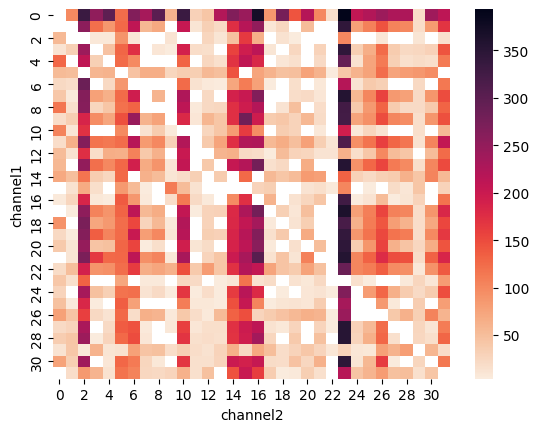

In [ ]:

df = pd.DataFrame(data[76])
df.columns = ["channel1","channel2","statsvalue"]
df = df.sort_values(by="statsvalue",ascending=False)
print(df.head(5))
heatmap_data = pd.pivot_table(df, values='statsvalue', index=['channel1'], columns='channel2')
# Set the color map for the heatmap
cmap = sns.cm.rocket_r

# Set NaN for cells where channel1 and channel2 are not found in dataframe
for i in range(32):
    for j in range(32):
        if (i not in heatmap_data.index) or (j not in heatmap_data.columns):
            heatmap_data.loc[i,j] = np.nan

# Create the heatmap
sns.heatmap(heatmap_data, cmap=cmap)
plt.show()

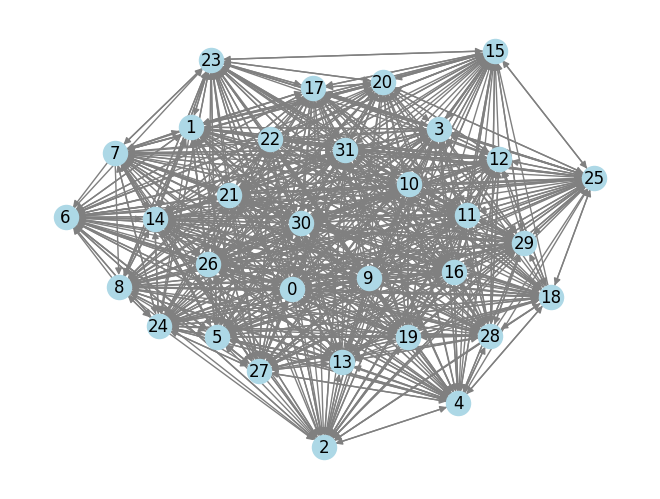

In [ ]:
# Create graph
import networkx as nx

G = nx.DiGraph()
lebn = len(data[76])
for i in range(0,lebn):
    G.add_edge(data[76][i][0], data[76][i][1])

pos = nx.spring_layout(G)
# pos = nx.spring_layout(G, k=0.15, iterations=20)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', arrows=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')

plt.show()
# 61 x 3 (61 edges)

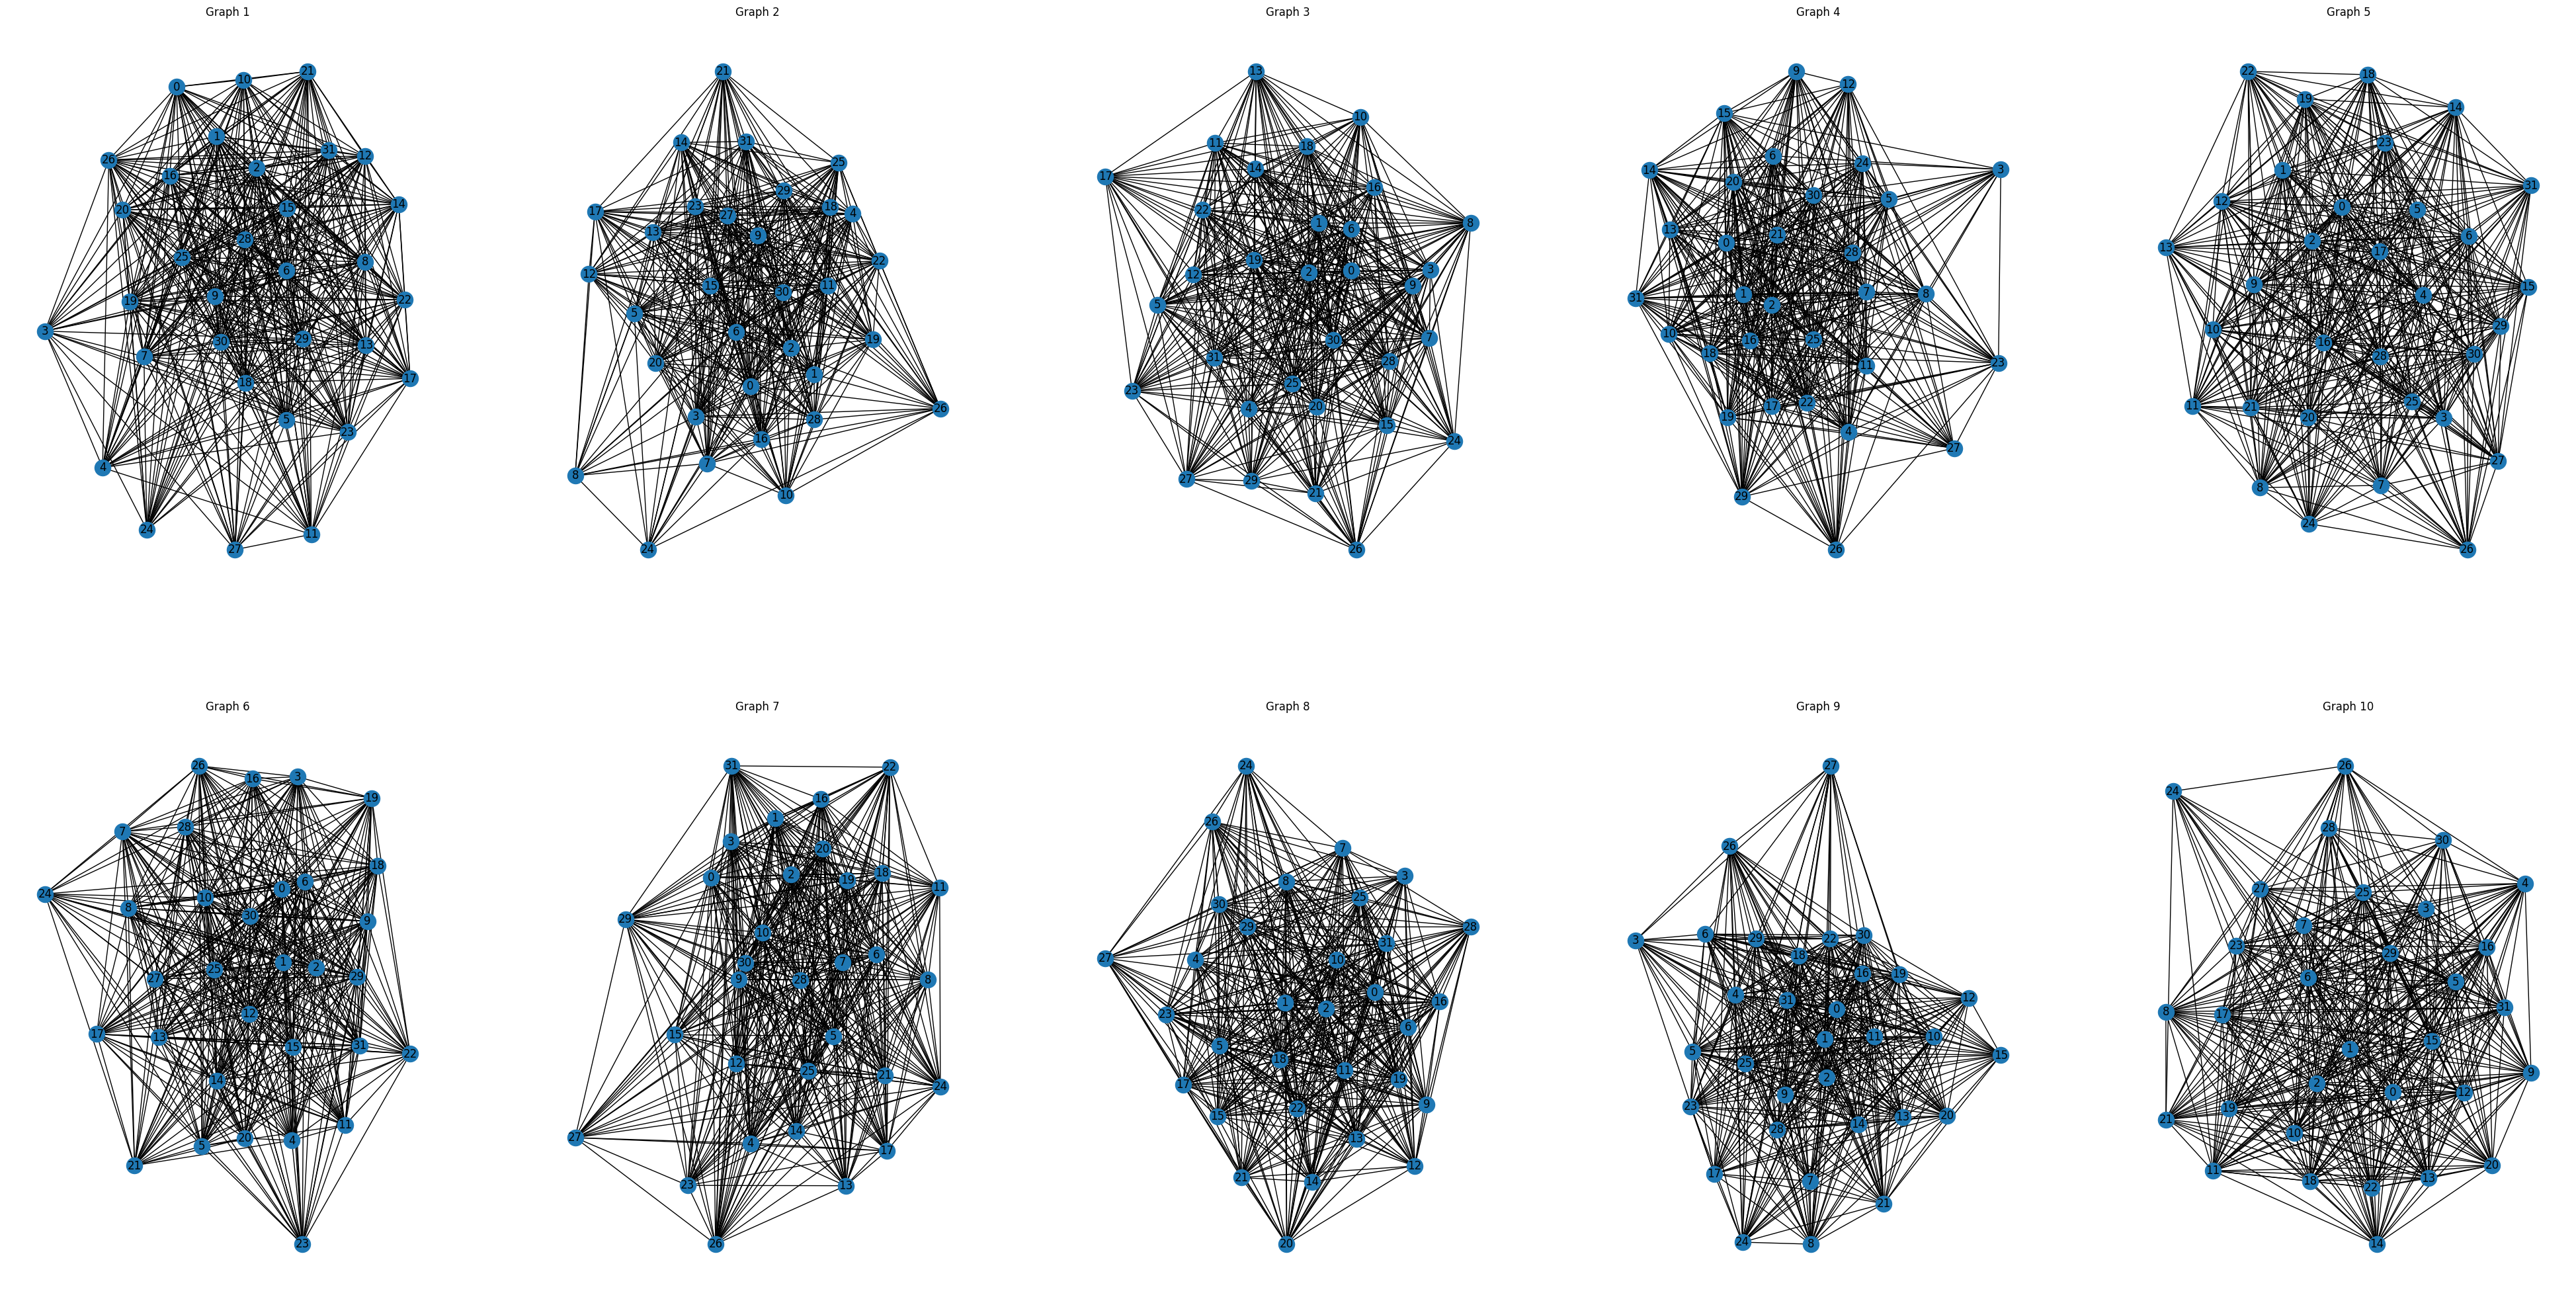

In [ ]:
import networkx as nx
import numpy as np

# Create an empty list to store all edge tuples
edge_tuples_list = []

# Generate 1280 random sets of edge tuples
num_samples = 1280
for i in range(num_samples):
    x = data[i] # choose a random number of edges for each sample
#     print(len(x))
    edge_tuples = []
    for j in x:
        start_vertex = j[0]
        end_vertex = j[1]
        weight = j[2]
        edge_tuple = (start_vertex, end_vertex, weight)
        edge_tuples.append(edge_tuple)
    edge_tuples_list.append(edge_tuples)

# Create a graph for each set of edge tuples using NetworkX
graphs = []
for edge_tuples in edge_tuples_list:
    G = nx.Graph()
    for edge in edge_tuples:
        start_vertex, end_vertex, weight = edge
        G.add_edge(start_vertex, end_vertex, weight=weight)
    graphs.append(G)

# Draw the first 10 graphs using Matplotlib
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 5, figsize=(50, 25))
for i in range(10):
    ax = axs[i//5, i%5]
    nx.draw(graphs[i], ax=ax, with_labels=True)
    ax.set_title(f"Graph {i+1}")
plt.show()


In [ ]:
graph_stats = []

for i in range(0,1280):

    param_list = []
    graph = graphs[i]

    # characterstic path length
    PL = nx.average_shortest_path_length(graph)
    param_list.append(PL)

    # global efficiency
    GE = nx.global_efficiency(graph)
    param_list.append(GE)


    # clustering coefficient
    CC = nx.average_clustering(graph)
    param_list.append(CC)


    # transitivity
    TV = nx.transitivity(graph)
    param_list.append(TV)


    # local efficiency
    LE = nx.global_efficiency(graph)
    param_list.append(LE)

    # modularity
    communities = list(greedy_modularity_communities(graph))
    MD = nx.algorithms.community.modularity(graph, communities)
    param_list.append(MD)


    # closeness centrality
    CL = nx.closeness_centrality(graph)
    avg_CL = sum(CL.values()) / len(CL)
    param_list.append(avg_CL)

    graph_stats.append(param_list)





In [ ]:
print(graph_stats[0])

[1.0987903225806452, 0.9506048387096774, 0.916761174875816, 0.9157220305569246, 0.9506048387096774, 0.005751768333761786, 0.9159288423535925]


In [ ]:
print(len(graph_stats))

1280


In [ ]:
print(len(graph_stats[0]))

7


In [ ]:
male_happy = []
female_happy = []
count = -1

for i in graph_stats:
    count = count +1
    if( count == 18 or count == 187 or count == 215 or count == 272 or count == 473 or count ==  599 or count == 674
        or count == 684 or count == 729 or count == 797 or count == 816 or count == 891 or count == 1031 or count == 1046
        or count == 1105 or count == 1137 or count == 1164):
        male_happy.append(i)
    elif(count == 63 or count == 97 or count == 135 or count == 317 or count == 324 or count == 365 or count == 432 or count == 514
            or count == 526 or count == 595 or count == 856 or count == 959 or count == 984 or count == 1239 or count == 1242):
#         print(count)
        female_happy.append(i)

print(len(female_happy))
# print(female_happy)

15


In [ ]:
PL_1 = [d[0] for d in male_happy]
GE_1 = [d[1] for d in male_happy]
CC_1 = [d[2] for d in male_happy]
TV_1 = [d[3] for d in male_happy]
LE_1 = [d[4] for d in male_happy]
MD_1 = [d[5] for d in male_happy]
CL_1 = [d[6] for d in male_happy]

PL_2 = [d[0] for d in female_happy]
GE_2 = [d[1] for d in female_happy]
CC_2 = [d[2] for d in female_happy]
TV_2 = [d[3] for d in female_happy]
LE_2 = [d[4] for d in female_happy]
MD_2 = [d[5] for d in female_happy]
CL_2 = [d[6] for d in female_happy]

t_PL, p_PL = stats.ttest_ind(PL_1,PL_2)
t_GE, p_GE = stats.ttest_ind(GE_1,GE_2)
t_CC, p_CC = stats.ttest_ind(CC_1,CC_2)
t_TV, p_TV = stats.ttest_ind(TV_1,TV_2)
t_LE, p_LE = stats.ttest_ind(LE_1,LE_2)
t_MD, p_MD = stats.ttest_ind(MD_1,MD_2)
t_CL, p_CL = stats.ttest_ind(CL_1,CL_2)

t_statistic_value = [t_PL,t_GE,t_CC,t_TV,t_LE,t_MD,t_CL]
p_value = [p_PL,p_GE,p_CC,p_TV,p_LE,p_MD,p_CL]

print(t_statistic_value)
print(p_value)




[1.426595906133557, -1.4265959061335305, -1.4090077991386274, -1.4256978424798161, -1.4265959061335305, -0.6496152962450171, -1.4484645777463618]
[0.1640214503636944, 0.16402145036370208, 0.16911433611209037, 0.16427852375312502, 0.16402145036370208, 0.5208840749302015, 0.15785925966591524]


In [ ]:
PL_1 = [d[0] for d in male_sad]
GE_1 = [d[1] for d in male_sad]
CC_1 = [d[2] for d in male_sad]
TV_1 = [d[3] for d in male_sad]
LE_1 = [d[4] for d in male_sad]
MD_1 = [d[5] for d in male_sad]
CL_1 = [d[6] for d in male_sad]

PL_2 = [d[0] for d in female_sad]
GE_2 = [d[1] for d in female_sad]
CC_2 = [d[2] for d in female_sad]
TV_2 = [d[3] for d in female_sad]
LE_2 = [d[4] for d in female_sad]
MD_2 = [d[5] for d in female_sad]
CL_2 = [d[6] for d in female_sad]

t_PL, p_PL = stats.ttest_ind(PL_1,PL_2)
t_GE, p_GE = stats.ttest_ind(GE_1,GE_2)
t_CC, p_CC = stats.ttest_ind(CC_1,CC_2)
t_TV, p_TV = stats.ttest_ind(TV_1,TV_2)
t_LE, p_LE = stats.ttest_ind(LE_1,LE_2)
t_MD, p_MD = stats.ttest_ind(MD_1,MD_2)
t_CL, p_CL = stats.ttest_ind(CL_1,CL_2)

t_statistic_value = [t_PL,t_GE,t_CC,t_TV,t_LE,t_MD,t_CL]
p_value = [p_PL,p_GE,p_CC,p_TV,p_LE,p_MD,p_CL]

print(t_statistic_value)
print(p_value)




[1.7207305747761361, -1.7207305747761164, -1.7231638531535436, -1.682622659116283, -1.7207305747761164, 0.3651577214756349, -1.7381762240697731]
[0.09559989650236851, 0.09559989650237216, 0.09515316205577998, 0.10282936206459437, 0.09559989650237216, 0.7175555584399929, 0.09243567616006748]


In [ ]:
male_sad = []
female_sad = []
count = -1

for i in graph_stats:
    count = count +1
    if( count == 3 or count == 178 or count == 219 or count == 275 or count == 455 or count == 621 or count == 659
           or count == 705 or count == 748 or count == 783 or count == 829 or count == 916 or count == 1022 or count == 1079
               or count == 1093 or count == 1154 or count == 1159):
        male_sad.append(i)
    elif( count == 48 or count == 118 or count == 144 or count == 295 or count == 327 or count == 361 or count == 413
           or count == 501 or count == 538 or count == 585 or count == 865 or count == 947 or count == 960 or count == 1160
               or count == 1213):
        female_sad.append(i)

print(len(female_sad))
print(female_sad)

15
[[1.0060483870967742, 0.9969758064516129, 0.9940484466867944, 0.9940140126522006, 0.9969758064516129, -3.3306690738754696e-16, 0.9941998106060606], [1.0665322580645162, 0.9667338709677419, 0.9389385098392389, 0.9373558800922367, 0.9667338709677419, -0.018214451545969873, 0.9414230286182684], [1.0120967741935485, 0.9939516129032258, 0.9885362495206769, 0.9884345311854605, 0.9939516129032258, 2.220446049250313e-16, 0.9886160714285714], [1.0262096774193548, 0.9868951612903226, 0.9744781841104144, 0.9743517075244438, 0.9868951612903226, 1.1102230246251565e-16, 0.9754072367583397], [1.0, 1.0, 1.0, 1.0, 1.0, -4.440892098500626e-16, 1.0], [1.028225806451613, 0.9858870967741935, 0.9728371199311131, 0.9726845924029023, 0.9858870967741935, 1.3322676295501878e-15, 0.9736757842341482], [1.0161290322580645, 0.9919354838709677, 0.9854843859432294, 0.9851522930687574, 0.9919354838709677, -1.1102230246251565e-16, 0.9851136761522792], [1.0100806451612903, 0.9949596774193549, 0.9912634408602146, 0.99

In [ ]:
arr = np.zeros(shape=(32, 7))

for j in range (0,7):
  val=0
  cnt=0
  for i in range (0,1280):
    cnt=cnt+1
    val=val+graph_stats[i][j]
    if(cnt%40==0):
      d=cnt//40-1
      val=val/40
     # val = round(val,4)
      arr[d][j]=val
      val=0

In [ ]:
print(arr[0])

[1.11980847 0.94009577 0.89038625 0.8897916  0.94009577 0.03747582
 0.89842326]


In [ ]:
print(len(arr))

32


In [ ]:
print(arr[23])

[1.00332661e+00 9.98336694e-01 9.96778793e-01 9.96749024e-01
 9.98336694e-01 6.93889390e-17 9.96848048e-01]


In [ ]:
print(arr)

[[ 1.11980847e+00  9.40095766e-01  8.90386251e-01  8.89791602e-01
   9.40095766e-01  3.74758177e-02  8.98423261e-01]
 [ 1.01804435e+00  9.90977823e-01  9.86622376e-01  9.86053052e-01
   9.90977823e-01 -8.76738118e-04  9.84667248e-01]
 [ 1.02202621e+00  9.88986895e-01  9.79797091e-01  9.79420082e-01
   9.88986895e-01 -1.98870876e-03  9.80223331e-01]
 [ 1.04128024e+00  9.79359879e-01  9.66961858e-01  9.65675295e-01
   9.79359879e-01 -7.23748957e-03  9.64972875e-01]
 [ 1.01139113e+00  9.94304435e-01  9.89595338e-01  9.89402621e-01
   9.94304435e-01  5.08547327e-05  9.89475141e-01]
 [ 1.02328629e+00  9.88356855e-01  9.77699242e-01  9.77513046e-01
   9.88356855e-01 -1.42097421e-03  9.78464814e-01]
 [ 1.07368952e+00  9.63155242e-01  9.29232095e-01  9.28553294e-01
   9.63155242e-01  7.51745222e-03  9.34195682e-01]
 [ 1.02736895e+00  9.86315524e-01  9.73828290e-01  9.73640538e-01
   9.86315524e-01  8.59743883e-03  9.74642216e-01]
 [ 1.00458669e+00  9.97706653e-01  9.95642433e-01  9.95629947e-0

In [ ]:
from numpy import save
save('end_product.npy', arr)

In [ ]:
# load numpy array from npy file
from numpy import load
# load array
data = load(r"C:\Users\tarun\Documents\College\Mini_Proj\end_product.npy",allow_pickle=True)
# print the array
print(data)

[[ 1.11980847e+00  9.40095766e-01  8.90386251e-01  8.89791602e-01
   9.40095766e-01  3.74758177e-02  8.98423261e-01]
 [ 1.01804435e+00  9.90977823e-01  9.86622376e-01  9.86053052e-01
   9.90977823e-01 -8.76738118e-04  9.84667248e-01]
 [ 1.02202621e+00  9.88986895e-01  9.79797091e-01  9.79420082e-01
   9.88986895e-01 -1.98870876e-03  9.80223331e-01]
 [ 1.04128024e+00  9.79359879e-01  9.66961858e-01  9.65675295e-01
   9.79359879e-01 -7.23748957e-03  9.64972875e-01]
 [ 1.01139113e+00  9.94304435e-01  9.89595338e-01  9.89402621e-01
   9.94304435e-01  5.08547327e-05  9.89475141e-01]
 [ 1.02328629e+00  9.88356855e-01  9.77699242e-01  9.77513046e-01
   9.88356855e-01 -1.42097421e-03  9.78464814e-01]
 [ 1.07368952e+00  9.63155242e-01  9.29232095e-01  9.28553294e-01
   9.63155242e-01  7.51745222e-03  9.34195682e-01]
 [ 1.02736895e+00  9.86315524e-01  9.73828290e-01  9.73640538e-01
   9.86315524e-01  8.59743883e-03  9.74642216e-01]
 [ 1.00458669e+00  9.97706653e-01  9.95642433e-01  9.95629947e-0

In [ ]:
male = []
female = []
count = 0

for i in data:
    count = count +1
    if( count == 1 or count == 6 or count == 7 or count == 5 or count == 12 or count == 16 or count == 17
           or count == 18 or count == 19 or count == 20 or count == 21 or count == 23 or count == 26 or count == 27
               or count == 28 or count == 29 or count == 30):
        male.append(i)
    else:
        female.append(i)

print(male)
print(female)


[array([1.11980847, 0.94009577, 0.89038625, 0.8897916 , 0.94009577,
       0.03747582, 0.89842326]), array([1.01139113e+00, 9.94304435e-01, 9.89595338e-01, 9.89402621e-01,
       9.94304435e-01, 5.08547327e-05, 9.89475141e-01]), array([ 1.02328629,  0.98835685,  0.97769924,  0.97751305,  0.98835685,
       -0.00142097,  0.97846481]), array([1.07368952, 0.96315524, 0.92923209, 0.92855329, 0.96315524,
       0.00751745, 0.93419568]), array([ 1.02051411,  0.98974294,  0.98067184,  0.98032188,  0.98974294,
       -0.00201991,  0.98146018]), array([ 1.07479839,  0.96260081,  0.93003892,  0.92920137,  0.96260081,
       -0.01331167,  0.93416016]), array([ 1.00957661e+00,  9.95211694e-01,  9.90913915e-01,  9.90828629e-01,
        9.95211694e-01, -1.77635684e-16,  9.90991422e-01]), array([1.07636089, 0.96181956, 0.92885306, 0.92742683, 0.96181956,
       0.00546565, 0.93418617]), array([1.00181452e+00, 9.99092742e-01, 9.98214054e-01, 9.98202368e-01,
       9.99092742e-01, 1.69309011e-16, 9.982

In [ ]:
BA_or_BSc_or_Ing=[]
MA_or_MSc_or_Ir=[]
phd=[]
High_school=[]

count=0

for i in data:
    count=count+1
    if count==(1 or 4 or 5 or 7 or 12 or 14 or 17 or 18 or 21 or 22 or 24 or 25 or 27 or 28 or 30 or 32):
         MA_or_MSc_or_Ir.append(i)
    if count==(2 or 6 or 8 or 9 or 11 or 13 or 16 or 20 or 29 or 31):
         BA_or_BSc_or_Ing.append(i)
    if count==(10 or 23):
         phd.append(i)
    if count==(3 or 15):
         High_school.append(i)


print(BA_or_BSc_or_Ing)
print(MA_or_MSc_or_Ir)
print(phd)
print(High_school)


[array([ 1.01804435e+00,  9.90977823e-01,  9.86622376e-01,  9.86053052e-01,
        9.90977823e-01, -8.76738118e-04,  9.84667248e-01])]
[array([1.11980847, 0.94009577, 0.89038625, 0.8897916 , 0.94009577,
       0.03747582, 0.89842326])]
[array([1.02157258, 0.98921371, 0.98000214, 0.97973538, 0.98921371,
       0.00567434, 0.98014402])]
[array([ 1.02202621,  0.9889869 ,  0.97979709,  0.97942008,  0.9889869 ,
       -0.00198871,  0.98022333])]


In [ ]:
avg_High_school = []
avg_PL = 0
avg_GE = 0
avg_CC = 0
avg_TV = 0
avg_LE = 0
avg_MD = 0
avg_CL = 0

# print(BA_or_BSc_or_Ing[0])
for i in High_school:
    # avg characterstic path length
    avg_PL += i[0]/(len(High_school))

    # avg global efficiency
    avg_GE += i[1]/(len(High_school))

    # avg clustering coefficient
    avg_CC += i[2]/(len(High_school))

    # avg transitivity
    avg_TV += i[3]/(len(High_school))

    # avg local efficiency
    avg_LE += i[4]/(len(High_school))

    # avg modularity
    avg_MD += i[5]/(len(High_school))

    # avg closeness centrality
    avg_CL += i[5]/(len(High_school))

avg_High_school.append(avg_PL)
avg_High_school.append(avg_GE)
avg_High_school.append(avg_CC)
avg_High_school.append(avg_TV)
avg_High_school.append(avg_LE)
avg_High_school.append(avg_MD)
avg_High_school.append(avg_CL)


print(avg_High_school)

[1.0220262096774198, 0.9889868951612899, 0.9797970911619511, 0.9794200819450726, 0.9889868951612899, -0.001988708761176976, -0.001988708761176976]
